In [31]:
import numpy as np
import pandas as pd
import sqlite3
import datetime
from matplotlib import pyplot as plt

from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer

# num_tok = len(tokenizer(my_string))

In [3]:
suff = '5feb2021'
dbname = 'data/session_info_feb5.db'

workbookname = 'data/sona_convos_annotated_%s.xlsx' % suff
surveyfilename = 'data/Questions_baseline_chatbot_February 5, 2021_16.06.csv'

In [4]:
cur = sqlite3.connect(dbname).cursor()

In [107]:
# load survey data sheet
raw_survey_df = pd.read_csv(surveyfilename)
survey_question_text_ts = raw_survey_df.loc[0]
raw_survey_df[:5]

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,...,Q255_2,Q255_3,Q255_4,Q255_5,Q255_6,Q58,Q57,SC0,SC2,id
0,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,If at any point you wanted to leave the conver...,Thank you for participating in our study. If y...,Score,PHQ-8 Patient Health Questionnaire- 8items,id
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}",...,"{""ImportId"":""QID311_2""}","{""ImportId"":""QID311_3""}","{""ImportId"":""QID311_4""}","{""ImportId"":""QID311_12""}","{""ImportId"":""QID311_13""}","{""ImportId"":""QID321_TEXT""}","{""ImportId"":""QID320_TEXT""}","{""ImportId"":""SC_by0GhYnW8z2dcq1""}","{""ImportId"":""SC_6gkccQmPIhIRJM9""}","{""ImportId"":""id""}"
2,2020-11-06 00:40:59,2020-11-06 00:45:57,Survey Preview,100,298,True,2020-11-06 00:45:58,R_1rAOxkXtOyiprCR,preview,EN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,6,NaN
3,2020-11-06 01:05:24,2020-11-06 01:08:11,Survey Preview,100,167,True,2020-11-06 01:08:13,R_O2mBVurRhoHtoHv,preview,EN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,17,NaN
4,2020-12-01 12:15:36,2020-12-01 12:15:36,Survey Test,100,0,True,2020-12-01 12:15:36,R_d1rrLLibNXatf6J,test,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,15,NaN


In [6]:
# load conversation sheets
convos = pd.read_excel(workbookname, engine='openpyxl', sheet_name=None)
convo_ids = list(convos.keys())

In [7]:
print('Example convo ids: ', convo_ids[:5])
convos[convo_ids[10]][:5]

Example convo ids:  ['9244_22cee091', '50081_a05ac73b', '50321_27d7083e', '38917_bca8e1ae', '46238_3e041c3a']


,Flow Index,User Message,Bot Response,helpful,error,why_leave
0,0,START,"Hi, it’s great to meet you!",1.0,NaN,na
1,1,How are you?,How are you doing?,NaN,1.0,na
2,2,I am alright. Feeling a little down :(,I've heard that many people stay at home more ...,1.0,NaN,na
3,3,Yes,I see. I've also heard that many people's diet...,1.0,NaN,na
4,4,I don't think so,Ok. These last few months have been really dif...,1.0,NaN,na


### Calculate statistics on conversations & annotations

In [188]:
convo_stats = [] # these are statistics on each participant's converstion 
# flow_stats = [] # these are statistics on each flow message


for cid in convo_ids: 
    
    sona, sid = cid.split('_')
    
    
    if len(sona) != 5:
        print('Admin testing system, omitting: ', cid)
        # Not a valid SONA (5 digit intiger), likely admin testing sona 9244
        continue
        
    if sona in ['38917', '46238', '50321', '50081']:
        print('Was in pilot, omitting: ', cid)
        # This was a pilot conversation before we changed the binary "want to leave" to multiple choice "why leave" question
        continue
        
        
    results = cur.execute('select sid, joined_time from session_meta_data where pid=="%s"' % sona).fetchall()
    [convo_joined_time,] = [int(x[1]) for x in results if x[0].startswith(sid)]
    
    convo = convos[cid]
    num_messages = convo.shape[0]
    
    # Counts of likes, errors, leave
    num_helpful = convo['helpful'].sum()
    num_error = convo['error'].sum()
    num_leave = (convo['why_leave'].dropna() != 'na').sum()
    
    # When first leave? 
    want_to_leave = convo['why_leave'].dropna() != 'na'
    first_leave = convo['why_leave'].dropna()[want_to_leave].index.min()
    
    # Why first leave?
    why_first_leave = convo['why_leave'][first_leave] if first_leave is not np.nan else 'complete_convo'
    
    # Error to leave? How long after the first error did they want to leave?
    first_error = convo['error'].dropna().index.min()
    error_to_leave = first_leave - first_error
    error_before_leave = first_error < first_leave
    error_is_leave = first_error == first_leave
    
    # participant engagement: how much participant wrote in conversation
    message_tok = [len(tokenizer(x)) if x is not np.nan else 0 for x in convo['User Message'][1:].values]
    avg_message_tok = np.mean(message_tok)
    tot_message_tok = np.sum(message_tok)
    
    
    
    convo_stats.append([cid, sona, sid, datetime.datetime.fromtimestamp(convo_joined_time), 
                        num_messages, num_helpful, num_error, num_leave, 
                        first_leave, why_first_leave, first_error, error_to_leave, 
                        error_before_leave, error_is_leave,
                        avg_message_tok, tot_message_tok])
    
#     What kinds of messages did people dis/like
#     Is the effect of errors worse for people who are more depressed/anxious?
#     Was the bot more likely to make mistakes on certain messages?
#     Were mistakes more common for certain message types? Were certain types more helpful?
#     Did certain people like/prefer certain types of messages? E.g., depressed people prefer chatting to tips
#     Length of response to flow message

raw_convo_stats_df = pd.DataFrame(convo_stats, columns = ['cid', 'sona', 'session_id', 'convo_joined_datetime', 
                                                      'num_messages', 'num_helpful', 'num_error', 'num_leave', 
                                                     'first_leave', 'why_first_leave', 'first_error', 'error_to_leave', 
                                                      'error_before_leave', 'error_is_leave', 
                                                      'avg_message_tok', 'tot_message_tok'])

Admin testing system, omitting:  9244_22cee091
Was in pilot, omitting:  50081_a05ac73b
Was in pilot, omitting:  50321_27d7083e
Was in pilot, omitting:  38917_bca8e1ae
Was in pilot, omitting:  46238_3e041c3a


In [9]:
print('DF dimensions: ', convo_stats_df.shape)
convo_stats_df[:5]

DF dimensions:  (133, 16)


,cid,sona,session_id,convo_joined_datetime,num_messages,num_helpful,num_error,num_leave,first_leave,why_first_leave,first_error,error_to_leave,error_before_leave,error_is_leave,avg_message_tok,tot_message_tok
0,50375_82125de0,50375,82125de0,2021-01-27 09:44:29,29,0.0,4.0,0,NaN,complete_convo,13.0,NaN,False,False,3.928571,110
1,45644_643fcbec,45644,643fcbec,2021-01-27 10:16:35,19,5.0,2.0,1,18.0,nofeedback,10.0,8.0,True,False,22.611111,407
2,41923_87b34bf0,41923,87b34bf0,2021-01-27 10:47:48,29,16.0,10.0,6,4.0,nolisten,4.0,0.0,False,True,3.428571,96
3,51190_8d0fe287,51190,8d0fe287,2021-01-27 11:07:59,29,28.0,1.0,6,2.0,nocare,7.0,-5.0,False,False,8.035714,225
4,44598_937c2601,44598,937c2601,2021-01-27 11:06:01,28,5.0,0.0,0,NaN,complete_convo,NaN,NaN,False,False,13.148148,355


### Add a datetime column to survey responses so response time can be compared with conversation time

In [108]:
for i in raw_survey_df.index:
    try:
        raw_survey_df.loc[i, 'EndDate_datetime'] = datetime.datetime.strptime(raw_survey_df.loc[i, 'EndDate'], '%Y-%m-%d %H:%M:%S')
    except:
        pass

### Drop duplicate annotated conversations and survey responses for participants
Make sure to end up with one annotated convo and one survey response for each participant

if two conversations are annotated, drop the one that happened later in time


if two survey responses:

    * if one is 'Finished', drop the other
    * else take the one closer in time to the conversation

In [189]:
survey_df = raw_survey_df.copy()
convo_stats_df = raw_convo_stats_df.copy()

print('Start convo dim:', convo_stats_df.shape)
print('Start survey dim:', survey_df.shape)

drop_cids = []

for sona in convo_stats_df['sona'].unique():
    s = survey_df[survey_df['id'] == sona]
    a = convo_stats_df[convo_stats_df['sona'] == sona]
    
    # If more than two annotated conversations, drop later one
    if a.shape[0] > 1: 
        # index of last conversation: 
        dropidx = a['convo_joined_datetime'].idxmax()
        
        print('Dropping extra annoated convo for sona ', sona)
        cid = convo_stats_df.loc[dropidx, 'cid']
        convo_stats_df.drop(index=dropidx, inplace=True)
        drop_cids.append(cid)
        
        
    if s.shape[0] > 1: 
        if sum(s['Finished'] == 'True') == 1:
            
            # index of the non-finished survey response
            dropidx = s[s['Finished'] == 'False'].index
            reason = 'unfinished'
        else:
            
            # list of indices for survey rows for participant
            idxs = s.index

            # calculate absolute time distance of survey response to conversation
            time_dists = [abs((x - a['convo_joined_datetime'].values[0]).total_seconds()) for x in s['EndDate_datetime']]
            
            # rows to drop from survey dataframe are those NOT closest to annotations
            dropidx = idxs[time_dists != np.min(time_dists)]
            reason = 'less close in time'
        
        print('Dropping extra survey response for sona %s because %s' % (sona, reason))
        survey_df.drop(index=dropidx, inplace=True)
        
print('End convo dim:', convo_stats_df.shape)
print('End survey dim:', survey_df.shape)
print('Dropped conversations with cids:', drop_cids)


Start convo dim: (133, 16)
Start survey dim: (215, 78)
Dropping extra survey response for sona 44692 because less close in time
Dropping extra survey response for sona 51389 because unfinished
Dropping extra survey response for sona 50638 because less close in time
Dropping extra survey response for sona 48240 because unfinished
Dropping extra survey response for sona 45566 because unfinished
Dropping extra survey response for sona 48169 because unfinished
Dropping extra annoated convo for sona  46440
Dropping extra survey response for sona 46440 because unfinished
Dropping extra survey response for sona 48039 because less close in time
Dropping extra survey response for sona 47727 because unfinished
Dropping extra survey response for sona 44600 because unfinished
Dropping extra survey response for sona 50082 because unfinished
Dropping extra survey response for sona 45849 because unfinished
Dropping extra survey response for sona 49423 because less close in time
Dropping extra survey 

# Make participant data frame

### Aggregate survey and conversation records

In [121]:
participant_df = survey_df.merge(convo_stats_df, left_on='id', right_on='sona', how='right')
participant_df.shape

(132, 94)

In [ ]:
# Uncomment to print column names & question text, if desired:

# for i in participant_df.columns:
#     if i in survey_question_text_ts.index:
#         print('%s\t%s' % (i, survey_question_text_ts[i].replace('\n', ' ')))
#     else:
#         print('%s\t%s' % (i,i))

### Rename columns and convert types

In [304]:
# 'Q249_1': mood before chat?
# 'Q55_1': mood after chat?

for col in ['SC0', 'SC2', 'Q249_1','Q55_1']:
    participant_df[col] = participant_df[col].astype(float)
    
    
participant_df['phq8'] = participant_df['SC2']

participant_df['mood_before'] = participant_df['Q249_1']
participant_df['mood_after'] = participant_df['Q55_1']
participant_df['mood_change'] = participant_df['mood_after'] - participant_df['mood_before']


# Q242: Have you ever chatted with a chatbot?
# Q251: Have you ever used a chatbot for mental health?
# Q219: how hard to imagine mood?
participant_df['chatbot_experience'] = participant_df['Q242'] == 'Yes'
participant_df['chatbot_mh_experience'] = participant_df['Q251'] == 'Yes'
participant_df['cant_imagine_mood'] = participant_df['Q219'] == 'Not at all'



likert_options = ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree']


# post chat survey on perception
temp = '''post_survey_9_1
post_survey_9_2
post_survey_9_3
post_survey_9_4
post_survey_9_5
post_survey_10_1
post_survey_10_2
post_survey_10_3
post_survey_10_4
post_survey_10_5
post_survey_10_6'''
positive_perception_cols = temp.split('\n')


# post chat survey on concerns with a chatbot
temp = '''Q255_1
Q255_2
Q255_3'''
concern_cols = temp.split('\n')

# openess to talking to a bot
temp='''Q255_4
Q255_5
Q255_6'''
open_to_bot_cols = temp.split('\n')



for i in participant_df.index:
    
    positive_perception = 0    
    for col in positive_perception_cols:
        positive_perception += likert_options.index(participant_df.loc[i, col])
    
    concern = 0
    for col in concern_cols:
        concern += likert_options.index(participant_df.loc[i, col])
    
    open_to_bot = 0
    for col in open_to_bot_cols:
        open_to_bot += likert_options.index(participant_df.loc[i, col])
        
    participant_df.loc[i, 'positive_perception'] = positive_perception
    participant_df.loc[i, 'concern'] = concern
    participant_df.loc[i, 'open_to_bot'] = open_to_bot


### Threshold depression

In [325]:
participant_df['depressed'] = participant_df['phq8'] >= 10
participant_df['not_depressed'] = participant_df['phq8'] <= 5

depressed_sonas_df = participant_df[participant_df['depressed']][['sona']]
not_depressed_sonas_df = participant_df[participant_df['not_depressed']][['sona']]

# Make message level dataframe

In [236]:
flow_df = pd.read_csv('data/New_flow_1_2020.csv')

# clean up typo in strategy naming
typo_inds = flow_df['strategy_fixed'][flow_df['strategy_fixed'] == 'active listening'].index
for i in typo_inds:
    flow_df.loc[i, 'strategy_fixed'] = 'active_listening'

# shorten column name for convenience, clarity
flow_df['strategy'] = flow_df['strategy_fixed']

In [246]:
convo_dfs = [] # these are statistics on each participant's converstion 


for cid in participant_df['cid'].values: 
    
    sona, sid = cid.split('_')
    
    
    convo = convos[cid]
    
    # convert annotation checkboxes to booleans
    convo['helpful_bool'] = ~np.isnan(convo['helpful'])
    convo['error_bool'] = ~np.isnan(convo['error'])
    convo['leave_bool'] = convo['why_leave'] != 'na'

    
    # indicate first want to leave message
    want_to_leave = convo['why_leave'].dropna() != 'na'
    first_leave = convo['why_leave'].dropna()[want_to_leave].index.min()
    temp = [False]*convo.shape[0]
    if ~np.isnan(first_leave):
        temp[first_leave] = True
    convo['first_leave'] = temp
    
    
    # indicate first response error
    first_error = convo['error'].dropna().index.min()
    temp = [False]*convo.shape[0]
    if ~np.isnan(first_error):
        temp[first_error] = True
    convo['first_error'] = temp
    
    
    # participant engagement: how much participant wrote in conversation
    message_tok = [len(tokenizer(x)) if x is not np.nan else 0 for x in convo['User Message'].values]
    convo['user_message_len'] = message_tok
    

    # add participant identification
    convo['sona'] = sona
    convo['cid'] = cid
    
    
    # Join to append the message strategy
    convo = convo.merge(flow_df[['strategy']], how='left', left_on='Flow Index', right_index=True)
    
    
    convo_dfs.append(convo)
    
    
message_df = pd.concat(convo_dfs, axis=0)

In [247]:
print('Message_df dimension: ', message_df.shape)
message_df[:3]

Message_df dimension:  (3433, 15)


,Flow Index,User Message,Bot Response,helpful,error,why_leave,helpful_bool,error_bool,leave_bool,first_leave,first_error,user_message_len,sona,cid,strategy
0,0,START,"Hi, it’s great to meet you!",NaN,NaN,na,False,False,False,False,False,1,50375,50375_82125de0,neutral
1,1,thanks,How are you doing?,NaN,NaN,na,False,False,False,False,False,1,50375,50375_82125de0,chitchat
2,2,im okay,I've heard that many people stay at home more ...,NaN,NaN,na,False,False,False,False,False,3,50375,50375_82125de0,chitchat


# Write constructed dataframes to csvs

In [ ]:
participant_df.to_csv('data/participant_data_18feb2021.csv')

# Preliminary exploratory plots

## How bad were people feeling to start off?

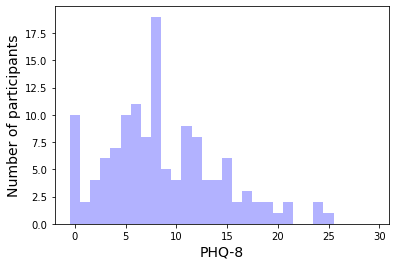

In [86]:
plt.hist(participant_df['phq8'], bins=np.arange(-.5,30.5), alpha=.3, color='b', label='phq8 at start')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('PHQ-8', fontsize=14)
plt.show()

## How did mood score before chat relate to phq8?

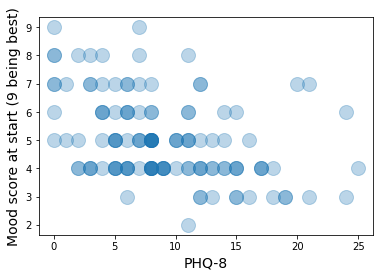

In [87]:
plt.plot(participant_df['phq8'], participant_df['mood_before'], 'o', alpha=.3, markersize=14)
plt.ylabel('Mood score at start (9 being best)', fontsize=14)
plt.xlabel('PHQ-8', fontsize=14)
plt.show()

## Did chatting with the bot provide any relief?

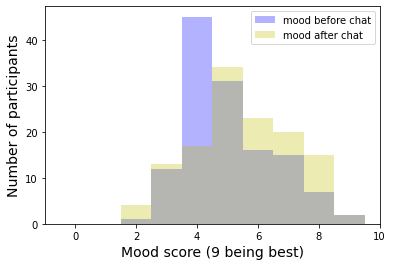

In [84]:

plt.hist(participant_df['mood_before'], bins=np.arange(-.5,10.5), alpha=.3, color='b', label='mood before chat')
plt.hist(participant_df['mood_after'], bins=np.arange(-.5,10.5), alpha=.3, color='y', label='mood after chat')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Mood score (9 being best)', fontsize=14)
plt.legend()
plt.show()



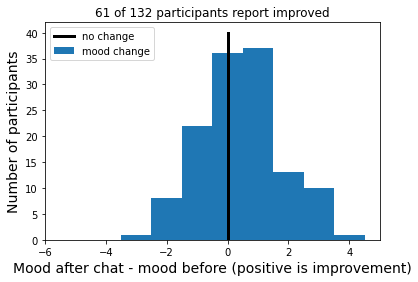

In [73]:
plt.hist(participant_df['mood_change'], bins=np.arange(-5.5,5.5), label='mood change')
plt.plot([0,0],[0,40], 'k', linewidth=3, label='no change')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Mood after chat - mood before (positive is improvement)', fontsize=14)
plt.title('%s of %s participants report improved' % (sum(participant_df['mood_change']>0), participant_df.shape[0]))
plt.legend()
plt.show()


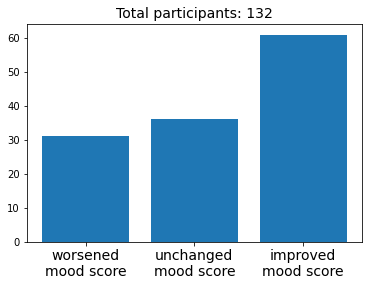

In [85]:
improved = sum(participant_df['mood_change'] > 0)
unchanged = sum(participant_df['mood_change'] == 0)
worsened = sum(participant_df['mood_change'] < 0)

temp = [worsened, unchanged, improved]
temp_ticks = ['worsened\nmood score', 'unchanged\nmood score', 'improved\nmood score']

plt.bar(range(len(temp)), temp)
plt.xticks(range(len(temp)), temp_ticks, fontsize=14)
plt.title('Total participants: %s' % participant_df.shape[0], fontsize=14)
plt.show()

### Was change in mood related to mood at start?

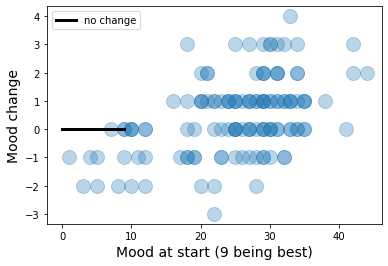

In [308]:
plt.plot(participant_df['mood_before'], participant_df['mood_change'], 'o', alpha=.3, markersize=14)
plt.plot([0, 9],[0, 0], 'k', linewidth=3, label='no change')
plt.ylabel('Mood change', fontsize=14)
plt.xlabel('Mood at start (9 being best)', fontsize=14)
plt.legend()
plt.show()

### Was positive perception related to mood at start?

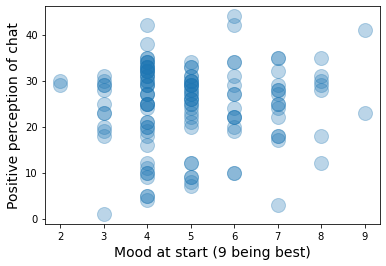

In [310]:
plt.plot(participant_df['mood_before'], participant_df['positive_perception'], 'o', alpha=.3, markersize=14)
plt.ylabel('Positive perception of chat', fontsize=14)
plt.xlabel('Mood at start (9 being best)', fontsize=14)
plt.show()

## Do people who are more familiar with chatbots experience more relief/benefit?

* Q242: Have you ever chatted with a chatbot? ['Yes' 'No' "I don't know" nan] 'chatbot_experience'
* Q251: Have you ever used a chatbot for mental health? ['Yes' 'No' "I don't know" nan] 'chatbot_mh_experience'
* Q219: how hard to imagine mood? ['Yes' 'No' "I don't know" nan] 'cant_imagine_mood'

In [137]:
print('Used chatbot for mental health: ', sum(participant_df['chatbot_mh_experience']))
print('Cannot imagine a bad mood: ', sum(participant_df['cant_imagine_mood']))

Used chatbot for mental health:  6
Cannot imagine a bad mood:  2


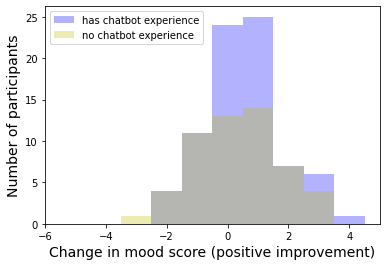

In [138]:
ind = participant_df['chatbot_experience'] 
plt.hist(participant_df[ind]['mood_change'], bins=np.arange(-5.5,5.5), alpha=.3, color='b', label='has chatbot experience')
plt.hist(participant_df[~ind]['mood_change'], bins=np.arange(-5.5,5.5), alpha=.3, color='y', label='no chatbot experience')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Change in mood score (positive improvement)', fontsize=14)
plt.legend()
plt.show()

## How long were participant messages?

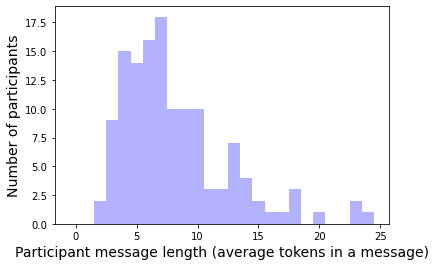

In [184]:
plt.hist(participant_df['avg_message_tok'], bins=np.arange(-.5, 25.5), alpha=.3, color='b')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Participant message length (average tokens in a message)', fontsize=14)
# plt.legend()
plt.show()

## Annotation overview

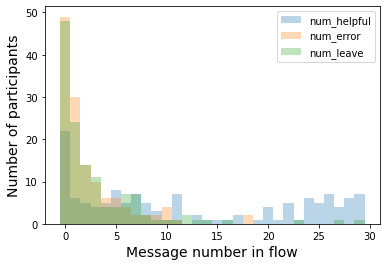

In [185]:
for col in ['num_helpful', 'num_error', 'num_leave']:
    plt.hist(participant_df[col], bins=np.arange(-.5,30.5), alpha=.3, label=col)

plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Message number in flow', fontsize=14)
plt.legend()
plt.show()

## When did people first want to leave the conversation

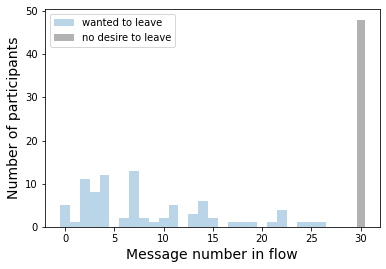

In [179]:
plt.hist(participant_df['first_leave'], bins=np.arange(-.5,30.5), alpha=.3, label='wanted to leave')
plt.bar([30], [np.isnan(participant_df['first_leave'].values).sum()], alpha=.3, color='k', label='no desire to leave')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Message number in flow', fontsize=14)
plt.legend()
plt.show()

In [178]:
a = sum(participant_df['first_leave'] <= 5)
b = participant_df.shape[0]
c = sum(np.isnan(participant_df['first_leave']))
print('Leave within first 5 messages: %s of %s (%.2f%%)' % (a, b, 100.*float(a)/b))
print('Never leave: %s of %s (%.2f%%)' % (c, b, 100.*float(c)/b))

Leave within first 5 messages: 37 of 132 (28.03%)
Never leave: 48 of 132 (36.36%)


## How long after the first error did individuals want to leave?

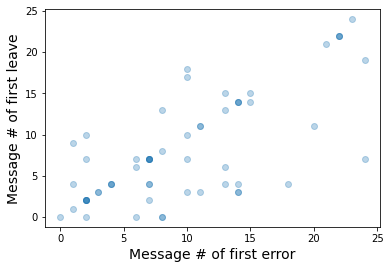

In [155]:
plt.plot(participant_df['first_error'], participant_df['first_leave'], 'o', alpha=.3)
plt.ylabel('Message # of first leave', fontsize=14)
plt.xlabel('Message # of first error', fontsize=14)
plt.show()

## What is the first reason to leave?

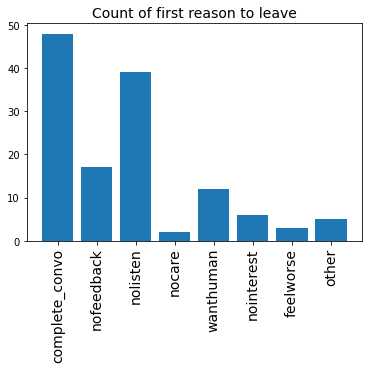

In [170]:
from collections import Counter
c = Counter(participant_df['why_first_leave'])
reasons = [x[0] for x in c.items()]
counts = [x[1] for x in c.items()]

plt.bar(range(len(reasons)), counts)
plt.xticks(range(len(reasons)), reasons, fontsize=14, rotation=90)
plt.title('Count of first reason to leave', fontsize=14)
plt.show()


## Do people who write more report mood improvement?

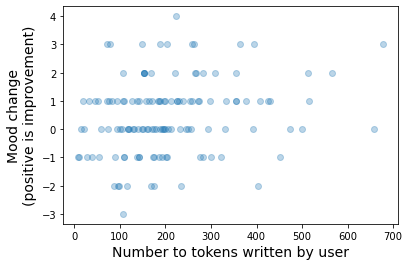

In [289]:
plt.plot(participant_df['tot_message_tok'], participant_df['mood_change'], 'o', alpha=.3)
plt.ylabel('Mood change\n(positive is improvement)', fontsize=14)
plt.xlabel('Number to tokens written by user', fontsize=14)
plt.show()

### Does bot performance relate to efficacy/relief?

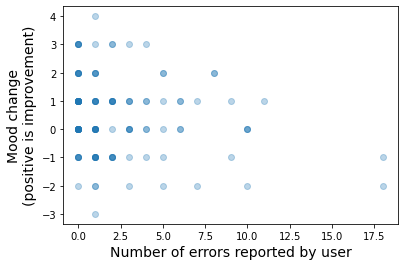

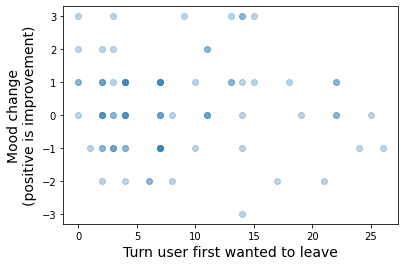

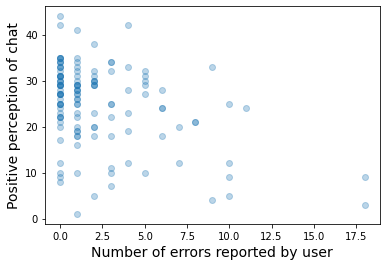

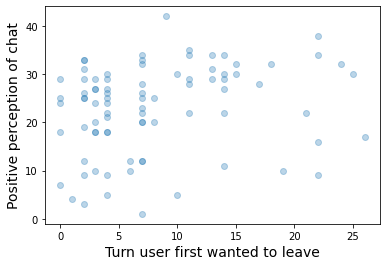

In [307]:
plt.plot(participant_df['num_error'], participant_df['mood_change'], 'o', alpha=.3)
plt.ylabel('Mood change\n(positive is improvement)', fontsize=14)
plt.xlabel('Number of errors reported by user', fontsize=14)
plt.show()



plt.plot(participant_df['first_leave'], participant_df['mood_change'], 'o', alpha=.3)
plt.ylabel('Mood change\n(positive is improvement)', fontsize=14)
plt.xlabel('Turn user first wanted to leave', fontsize=14)
plt.show()



plt.plot(participant_df['num_error'], participant_df['positive_perception'], 'o', alpha=.3)
plt.ylabel('Positive perception of chat', fontsize=14)
plt.xlabel('Number of errors reported by user', fontsize=14)
plt.show()


plt.plot(participant_df['first_leave'], participant_df['positive_perception'], 'o', alpha=.3)
plt.ylabel('Positive perception of chat', fontsize=14)
plt.xlabel('Turn user first wanted to leave', fontsize=14)
plt.show()


# 'positive_perception'
# 'concern'
# 'open_to_bot'

# Message level plots

In [248]:
print('Message_df dimension: ', message_df.shape)
message_df[:3]

Message_df dimension:  (3433, 15)


,Flow Index,User Message,Bot Response,helpful,error,why_leave,helpful_bool,error_bool,leave_bool,first_leave,first_error,user_message_len,sona,cid,strategy
0,0,START,"Hi, it’s great to meet you!",NaN,NaN,na,False,False,False,False,False,1,50375,50375_82125de0,neutral
1,1,thanks,How are you doing?,NaN,NaN,na,False,False,False,False,False,1,50375,50375_82125de0,chitchat
2,2,im okay,I've heard that many people stay at home more ...,NaN,NaN,na,False,False,False,False,False,3,50375,50375_82125de0,chitchat


In [249]:
turn_df = message_df.groupby('Flow Index').agg(np.sum)
turn_df[:3]

,helpful,error,helpful_bool,error_bool,leave_bool,first_leave,first_error,user_message_len
Flow Index,,,,,,,,
0,60.0,2.0,60,2,5,5,2,132
1,59.0,6.0,59,6,3,1,5,451
2,61.0,12.0,61,12,13,11,10,702


### When was the conversation helpful/error

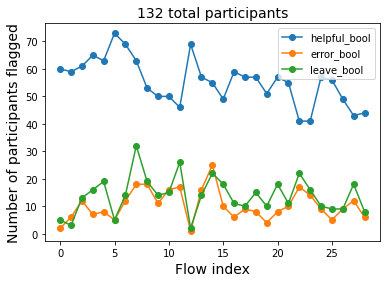

In [373]:
xs = np.arange(turn_df.shape[0])

for i, col in enumerate(['helpful_bool', 'error_bool', 'leave_bool']):
    plt.plot(xs, turn_df[col].values, 'o-', label=col)
    
plt.ylabel('Number of participants flagged', fontsize=14)
plt.xlabel('Flow index', fontsize=14)
plt.title('%s total participants' % participant_df.shape[0], fontsize=14)
plt.legend()
plt.show()

In [283]:
for i in [4, 5, 7, 12, 25]:
    print('Message %s text: \n%s\n' % (i, flow_df.loc[i, 'flow_fixed']))

Message 4 text: 
Ok. These last few months have been really difficult, and there's a lot going on in the world right now. Have you been feeling more negative emotions lately?

Message 5 text: 
I understand. What’s been the hardest part for you? 

Message 7 text: 
Thanks for sharing. Many people have felt more sad, lonely, or stressed lately, and that's ok, but it can make each day harder than usual.

Message 12 text: 
What would it take for your day to improve by just 1 point?

Message 25 text: 
I see. Sometimes it's nice to think about things that we are looking forward to. What do you most look forward to doing once the pandemic is over?  



### Errors correlate with wanting to leave

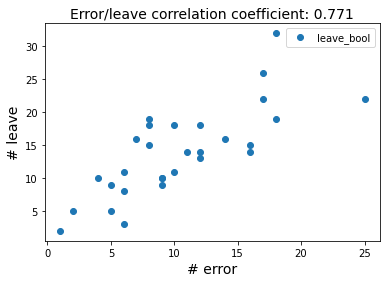

In [280]:
temp = np.corrcoef(turn_df[['error_bool', 'leave_bool']].values, rowvar=False) # Rowvar false sets columns to variable


plt.plot(turn_df['error_bool'].values, turn_df['leave_bool'].values, 'o', label=col)
plt.ylabel('# leave', fontsize=14)
plt.xlabel('# error', fontsize=14)
plt.title('Error/leave correlation coefficient: %.3f' % temp[0,1], fontsize=14)
plt.legend()
plt.show()

### What types of messages were most helpful to participants (depressed/not)

Check the strategy ordering matches!
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']


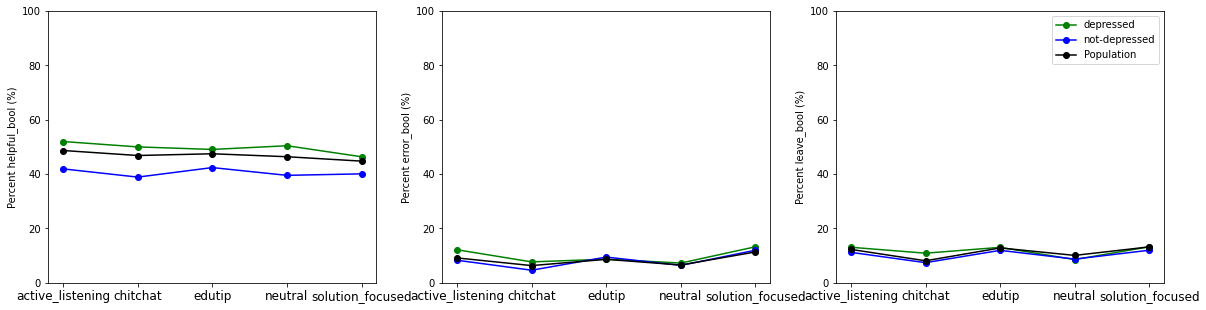

In [398]:
def temp_func(ax, df, labelname, color='b'):
    type_df = df.groupby('strategy').agg(np.mean)
    
    xs = np.arange(type_df.shape[0])
    print(type_df.index.values)

    for i, col in enumerate(['helpful_bool', 'error_bool', 'leave_bool']):
        ax[i].plot(xs, 100.0 * type_df[col].values, 'o-', label=labelname, color=color)
        ax[i].set_ylabel('Percent %s (%%)' % col)
        ax[i].set_xticks(xs)
        ax[i].set_xticklabels(type_df.index.values, fontsize=12)
        ax[i].set_ylim([0,100])
        
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

print('Check the strategy ordering matches!')

temp_func(ax, message_df.merge(depressed_sonas_df, on='sona', how='right'), 'depressed', color='g')
temp_func(ax, message_df.merge(not_depressed_sonas_df, on='sona', how='right'), 'not-depressed', color='b')
temp_func(ax, message_df, 'Population', color='k')


    
# plt.ylabel('Fraction participants flagged', fontsize=14)
# plt.xlabel('Strategy', fontsize=14)
# plt.title('%s total participants' % participant_df.shape[0], fontsize=14)
# plt.xticks(xs, type_df.index.values)
plt.legend()
plt.show()

## Engagement

### Engagement over the course of the conversation?

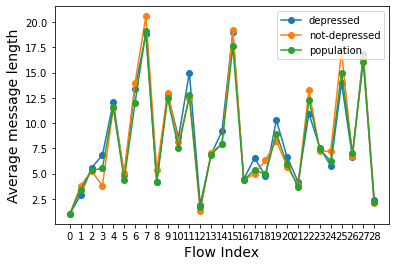

In [394]:
def temp_func(df, labelname):
    temp = df.groupby('Flow Index').agg(np.mean)
    ys = temp['user_message_len']
    xs = np.arange(temp.shape[0])
    plt.plot(xs, ys, 'o-', label=labelname)
    return xs, temp.index.values

temp_func(message_df.merge(depressed_sonas_df, on='sona', how='right'), 'depressed')
temp_func(message_df.merge(not_depressed_sonas_df, on='sona', how='right'), 'not-depressed')
xs, ticklabels = temp_func(message_df, 'population')
    
plt.ylabel('Average message length', fontsize=14)
plt.xlabel('Flow Index', fontsize=14)
plt.xticks(xs, ticklabels)
plt.legend()
plt.show()

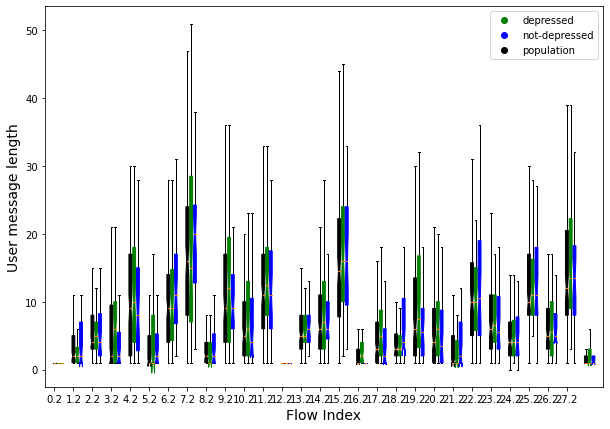

In [395]:
def temp_func(df, labelname, offset=0, color='b'):
    c = color
    for i in df['Flow Index'].unique():
        vals = df[df['Flow Index'] == i]['user_message_len'].values
        plt.boxplot(vals, positions = [i+offset], showfliers=False, notch=True, patch_artist=True, boxprops=dict(facecolor=c, color=c))
    plt.plot(np.NaN, 'o', color=c, label=labelname)
        
plt.subplots(figsize=(10,7))
temp_func(message_df.merge(depressed_sonas_df, on='sona', how='right'), 'depressed', offset=.2, color='g')
temp_func(message_df.merge(not_depressed_sonas_df, on='sona', how='right'), 'not-depressed', offset=.4, color='b')
temp_func(message_df, 'population', color='k')
    
plt.ylabel('User message length', fontsize=14)
plt.xlabel('Flow Index', fontsize=14)
plt.xticks(np.arange(28))
plt.legend()
plt.show()

### Engagement by message type

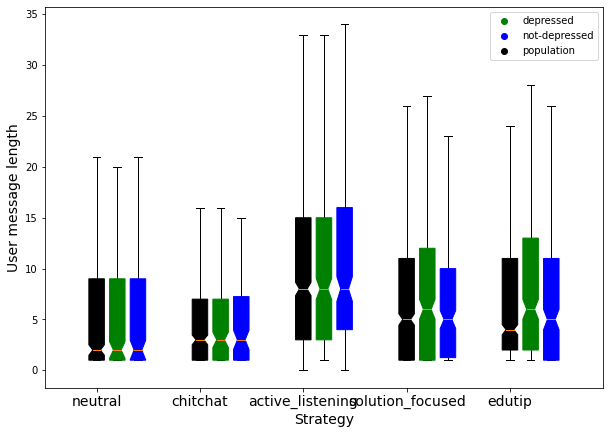

In [396]:
def temp_func(df, labelname, offset=0, color='b'):
    c = color
    strategies = df['strategy'].unique()
    for i, s in enumerate(strategies):
        vals = df[df['strategy'] == s]['user_message_len'].values
        plt.boxplot(vals, positions = [i+offset], showfliers=False, notch=True, patch_artist=True, boxprops=dict(facecolor=c, color=c))
    plt.plot(np.NaN, 'o', color=c, label=labelname)
        
plt.subplots(figsize=(10,7))
temp_func(message_df.merge(depressed_sonas_df, on='sona', how='right'), 'depressed', offset=.2, color='g')
temp_func(message_df.merge(not_depressed_sonas_df, on='sona', how='right'), 'not-depressed', offset=.4, color='b')
temp_func(message_df, 'population', color='k')
    
plt.ylabel('User message length', fontsize=14)
plt.xlabel('Strategy', fontsize=14)
strategies = message_df['strategy'].unique()
plt.xticks(np.arange(len(strategies)), strategies, fontsize=14)
plt.legend()
plt.show()


In [397]:
participant_df[participant_df['not_depressed']]['num_error'].mean()

2.4444444444444446

### Reasons for wanting to leave?

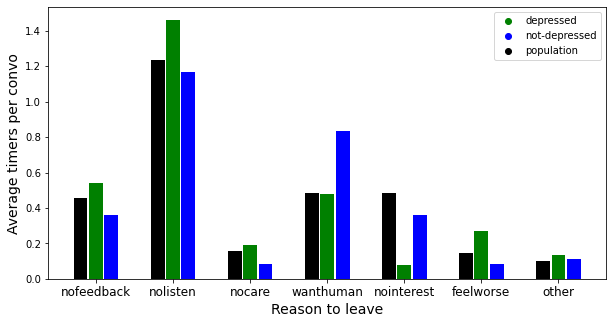

In [415]:
reasons_to_leave = ['nofeedback',
 'nolisten',
 'nocare',
 'wanthuman',
 'nointerest',
 'feelworse',
 'other']

def temp_func(df, labelname, color, offset=0):
    num_convo = float(df['sona'].unique().shape[0])
    c = Counter(df[df['leave_bool']]['why_leave'].values)
    for r, reason in enumerate(reasons_to_leave):
        plt.bar(r+offset, c[reason] / num_convo, color=color, width=.18)
    plt.plot(np.NaN, 'o', color=color, label=labelname)
    

plt.subplots(figsize=(10,5))    
temp_func(message_df.merge(depressed_sonas_df, on='sona', how='right'), 'depressed', color='g', offset=.2)
temp_func(message_df.merge(not_depressed_sonas_df, on='sona', how='right'), 'not-depressed', color='b', offset=.4)
temp_func(message_df, 'population', color='k')


plt.ylabel('Average timers per convo', fontsize=14)
plt.xlabel('Reason to leave', fontsize=14)
plt.xticks(np.arange(len(reasons_to_leave))+.2, reasons_to_leave, fontsize=12)
plt.legend()
plt.show()